# Loan Eligibility

The task simulates a set of clients. Some of them are financially OK, but others are running out of money. Your task is to identify clients, whom we can help by offering them a loan. Your tasks are:
1. Look into the customers.parquet file. Calculate average age.
2. Explore the customers.parquet file. How’s the data quality?
3. Examine the loans.parquet file. Can you spot some possible discrimination?
4. The transactions file contains customer transactions. You’ll soon be asked to train a model - explain your approach to using this data, and calculate the necessary features.
5. Use the available datasets to create train and validation datasets for the task of iden- tifying, which clients should we approach with a loan offer.
6. Train and evaluate a machine learning model for the aforementioned task. Explain your approach as much as possible.
7. Hypothetically, could you improve the solution? What would you require for it?

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
# Read files and look at the shapes and the relative headers
df_customers = pd.read_parquet('customers.parquet', engine='pyarrow')
df_loans = pd.read_parquet('loans.parquet', engine='pyarrow')
df_transactions = pd.read_parquet('transactions.parquet', engine='pyarrow')
print('Shapes of the datasets:')
print('customers: ', df_customers.shape)
print('loans: ', df_loans.shape)
print('transactions: ', df_transactions.shape)

print(' ')

print('Headers of the datasets:')
print('Customers:')
print(df_customers.head())
print(' ')

print('Loans:')
print(df_loans.head())
print(' ')

print('Transactions:')
print(df_transactions.head())

Shapes of the datasets:
customers:  (2500, 4)
loans:  (3203, 4)
transactions:  (91931, 4)
 
Headers of the datasets:
Customers:
         ID GENDER  AGE   INCOME
0  M5FQZHG1      F   37  10843.0
1  JPOALDTW      M   38   9419.0
2  QHJXRE6A      M   37  10850.0
3  LKS17XRW      M   35  10107.0
4  V5UPOIAW      F   34  10323.0
 
Loans:
            ID        DATE  AMOUNT   OUTCOME
1351  LG0PC60M  2022-04-27   24415  Declined
5     YNRVXFHU  2022-01-24   24883  Declined
1437  IQIT/RIF  2022-04-16   21650  Declined
1064  ZQYTNBWX  2022-03-09   19822  Declined
1956  JZHEH32O  2022-05-15   17996  Declined
 
Transactions:
              ID        DATE  AMOUNT  BALANCE
186724  HW6AIBVF  2022-07-23   -3033  17811.0
209157  JYMG2Q4S  2022-08-17    -777   8558.0
189985  BUETXTEY  2022-07-27    -501  26641.0
182248  O+AEF2OT  2022-07-18     -64      NaN
130378  TFHGRG46  2022-05-20   -1335      NaN


In [3]:
# Check Data types of the columns for each df
print('Customers columns types')
print(df_customers.dtypes)
print(' ')

print('Loans columns types')
print(df_loans.dtypes)
print(' ')

print('Transactions columns types')
print(df_transactions.dtypes)

Customers columns types
ID         object
GENDER     object
AGE         int64
INCOME    float64
dtype: object
 
Loans columns types
ID         object
DATE       object
AMOUNT      int64
OUTCOME    object
dtype: object
 
Transactions columns types
ID          object
DATE        object
AMOUNT       int64
BALANCE    float64
dtype: object


# QUESTION 1: Look into the customers.parquet file. Calculate average age

In [4]:
# Check NaN in AGE 
print('Number of NaN values in Age: ', df_customers['AGE'].isna().sum())
print('Average age for ID in Customers: ', np.mean(df_customers.AGE))

Number of NaN values in Age:  0
Average age for ID in Customers:  859027.8408


The mean gives back an absurd value. I will check the age range among the customers

In [5]:
# Print min, max, std age to see the range of age in the df
print('Lower age: ', np.min(df_customers.AGE))
print('Maximum age: ', np.max(df_customers.AGE))
print('Std age: ', df_customers.AGE.std())
print("Number of people with age equal to or above 100:", len(df_customers[df_customers['AGE'] > 100]))

Lower age:  19
Maximum age:  2147483647
Std age:  42949672.25208513
Number of people with age equal to or above 100: 1


The mean is affected by an absurd value imputed to one customer. I will check the distribution to see the realistic range of ages among the customers

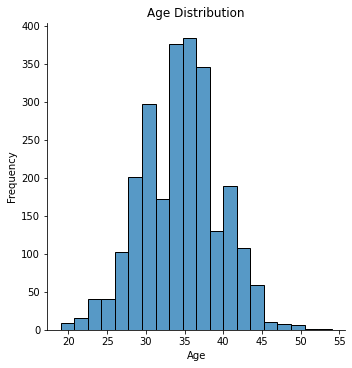

In [6]:
# Check the distribution removing values above 100 in order to verify the quality of the column AGE
# Filter the DataFrame to exclude values above 100 in the 'AGE' column
filtered_df = df_customers[df_customers['AGE'] <= 100]

# Plot the histogram
sns.displot(data=filtered_df, x="AGE", bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [7]:
#SOLUTION
# Filtering the DataFrame removing unrealistic values 
print('Lower age after in the cleaned column: ', np.min(filtered_df.AGE))
print('Maximum age in the cleaned column: ', np.max(filtered_df.AGE))
print("Mean age in the cleaned column:", round(np.mean(filtered_df.AGE), 2)) #solution

Lower age after in the cleaned column:  19
Maximum age in the cleaned column:  54
Mean age in the cleaned column: 34.4


For the modeling part, I will impute the anomaly value with the mean of population 

In [8]:
# Calculate mean age excluding values above 100
mean_age = np.mean(df_customers.loc[df_customers['AGE'] <= 100, 'AGE'])

# Replace values above 100 with mean age
df_customers.loc[df_customers['AGE'] > 100, 'AGE'] = mean_age

# QUESTION 2: Explore the customers.parquet file. How’s the data quality?

In [9]:
print(df_customers.shape)
df_customers.head()

(2500, 4)


,ID,GENDER,AGE,INCOME
0,M5FQZHG1,F,37.0,10843.0
1,JPOALDTW,M,38.0,9419.0
2,QHJXRE6A,M,37.0,10850.0
3,LKS17XRW,M,35.0,10107.0
4,V5UPOIAW,F,34.0,10323.0


In [10]:
# Check ID column 
print('Missing ID for df_customers: ', df_customers.ID.isna().sum())
print('Distinct ID for df_customers: ', df_customers.ID.nunique())
print('ID duplicates for df_customers: ', df_customers.duplicated(subset=['ID']).sum())

Missing ID for df_customers:  0
Distinct ID for df_customers:  2500
ID duplicates for df_customers:  0


From a first exploration, there are no problems with the column ID. It has no duplicates or missing ID associated with the customers.

In [11]:
# Check Gender column
print('Missing GENDER for df_customers: ', df_customers.GENDER.isna().sum())
df_customers.GENDER.value_counts()

Missing GENDER for df_customers:  0


M    1262
F    1238
Name: GENDER, dtype: int64

In [12]:
# Check if ID is associated with one single GENDER
# Group by 'ID' and count unique values of GENDER
gender_counts = df_customers.groupby('ID')['GENDER'].nunique()

# Check if any count is greater than 1
are_multiple_genders = (gender_counts > 1).any()

if are_multiple_genders:
    print("Some IDs are associated with more than one gender.")
else:
    print("Every ID is associated with only one gender.")

Every ID is associated with only one gender.


From a first exploration, also GENDER does not reveal any critical issues. There is a 50% split between M and F, there are no missing values, and there are no cases where ID is associated with multiple genders

In [13]:
# Check AGE column (exploration started in question 1 above)
# Check if ID is associated with one single AGE
# Group by 'ID' and count unique values of AGE
age_counts = df_customers.groupby('ID')['AGE'].nunique()

# Check if any count is greater than 1
are_multiple_ages = (age_counts > 1).any()

if are_multiple_genders:
    print("Some IDs are associated with more than one age.")
else:
    print("Every ID is associated with only one age.")

Every ID is associated with only one age.


Missing INCOME for df_customers:  375
Percentage Missing values for INCOME:  15.0
Lower INCOME:  6163.0
Maximum INCOME:  13377.0


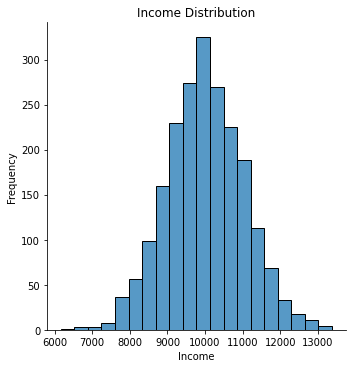

In [14]:
# Check INCOME column 
print('Missing INCOME for df_customers: ', df_customers.INCOME.isna().sum())
print('Percentage Missing values for INCOME: ', (df_customers.INCOME.isna().sum()/len(df_customers['INCOME'])*100))
print('Lower INCOME: ', np.min(df_customers.INCOME))
print('Maximum INCOME: ', np.max(df_customers.INCOME))

# Plot the histogram
sns.displot(data=df_customers, x="INCOME", bins=20)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

Overall, from just a tecnical perspective, also the Income does not have significant issues. It represents a normal distribution with a max income of 13377 and a lower of 6163. The only issue that can be fixed is the relatively low percentage of missing values. However, it is a problem that can be workarounded by using imputation of missing values with mean as shown in the step below. 

In [15]:
# Impute missing values of INCOME with the mean
df_customers['INCOME'] = df_customers['INCOME'].fillna(df_customers['INCOME'].mean())

# Map the values in the 'GENDER' column to binary values
gender_map = {'M': 0, 'F': 1}
df_customers['GENDER'] = df_customers['GENDER'].map(gender_map)

print('New shape of df_customers: ', df_customers.shape)
df_customers.head()

New shape of df_customers:  (2500, 4)


,ID,GENDER,AGE,INCOME
0,M5FQZHG1,1,37.0,10843.0
1,JPOALDTW,0,38.0,9419.0
2,QHJXRE6A,0,37.0,10850.0
3,LKS17XRW,0,35.0,10107.0
4,V5UPOIAW,1,34.0,10323.0


# QUESTION 3: Examine the loans.parquet file. Can you spot some possible discrimination?

In [16]:
# Check quality ID customers 
print('Shape of df_loans: ', df_loans.shape)
print('Missing ID for df_loans: ', df_loans['ID'].isna().sum())
print('Distinct ID for df_loans: ', df_loans.ID.nunique())
print('ID duplicates for df_loans: ', df_loans.duplicated(subset=['ID']).sum())
print(' ')

df_loans.head()

Shape of df_loans:  (3203, 4)
Missing ID for df_loans:  0
Distinct ID for df_loans:  1348
ID duplicates for df_loans:  1855
 


,ID,DATE,AMOUNT,OUTCOME
1351,LG0PC60M,2022-04-27,24415,Declined
5,YNRVXFHU,2022-01-24,24883,Declined
1437,IQIT/RIF,2022-04-16,21650,Declined
1064,ZQYTNBWX,2022-03-09,19822,Declined
1956,JZHEH32O,2022-05-15,17996,Declined


The amount of duplicates suggests that some customers asked for a loan multiple time

Missing DATE for df_transactions:  0
Lower DATE:  2022-01-02 00:00:00
Maximum DATE:  2022-08-30 00:00:00


<Figure size 648x648 with 0 Axes>

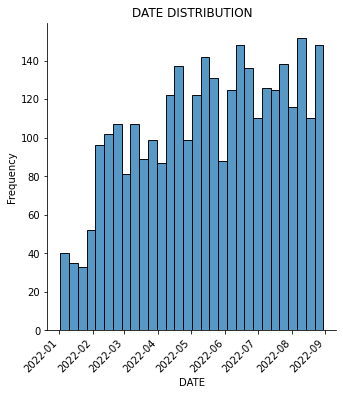

In [17]:
# Check Date 
df_loans['DATE'] = pd.to_datetime(df_loans['DATE'])
print('Missing DATE for df_transactions: ', df_loans['DATE'].isna().sum())
print('Lower DATE: ', np.min(df_loans.DATE))
print('Maximum DATE: ', np.max(df_loans.DATE))

# Plot the histogram
plt.figure(figsize=(9, 9))
sns.displot(data=df_loans, x="DATE", bins=30)
plt.title('DATE DISTRIBUTION')
plt.xlabel('DATE')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
# Count the occurrences of each unique ID 
id_counts = df_loans['ID'].value_counts()

# Count the number of IDs that asked for a loan more than once
multiple_requests_count = sum(id_counts > 1)
print("Number of people who asked multiple times:", multiple_requests_count)

Number of people who asked multiple times: 861


There are 861 ID out of 1348 (63.9%) ID who asked for a loan multiple times. 

In [19]:
# Check how many ID received a different OUTCOME

# Grouping the DataFrame by 'ID' and counting the number of unique values in the 'OUTCOME' column within each group
id_outcome_counts = df_loans.groupby('ID')['OUTCOME'].nunique()

# Selecting rows where the number of unique values in 'OUTCOME' is greater than 1
id_with_multiple_outcomes = id_outcome_counts[id_outcome_counts > 1]

# Printing the IDs with different outcomes
print('IDs with different outcomes: ', len(id_with_multiple_outcomes))

IDs with different outcomes:  252


There are 252 ID out of 1348 (18.7%) who received a different loan based on the time of the request. In order to come up with a binary classification for the next question, I will flag all the ID with 1 (i.e., TakeUp) or 0 (i.e., Declined) based on the most recent date.

In [20]:
# First step is to replace 'declined' with 0 and 'takeup' with 1 in the 'OUTCOME' column
df_loans['BINARY_OUTCOME'] = df_loans['OUTCOME'].replace({'Declined': 0, 'TakeUp': 1})
df_loans.head()

,ID,DATE,AMOUNT,OUTCOME,BINARY_OUTCOME
1351,LG0PC60M,2022-04-27,24415,Declined,0
5,YNRVXFHU,2022-01-24,24883,Declined,0
1437,IQIT/RIF,2022-04-16,21650,Declined,0
1064,ZQYTNBWX,2022-03-09,19822,Declined,0
1956,JZHEH32O,2022-05-15,17996,Declined,0


In the perspective of the modeling part, I will also investigate the column AMOUNT

Missing AMOUNT for df_loans:  0
Percentage Missing values for AMOUNT:  0.0
Lower AMOUNT:  7475
Maximum AMOUNT:  33205


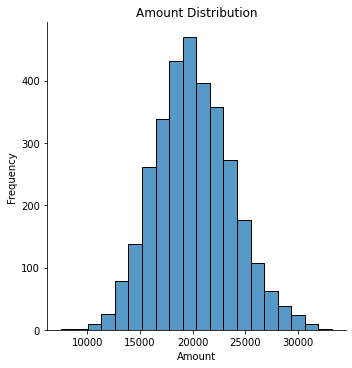

In [21]:
# Check AMOUNT column 
print('Missing AMOUNT for df_loans: ', df_loans.AMOUNT.isna().sum())
print('Percentage Missing values for AMOUNT: ', (df_loans.AMOUNT.isna().sum()/len(df_loans['AMOUNT'])*100))
print('Lower AMOUNT: ', np.min(df_loans.AMOUNT))
print('Maximum AMOUNT: ', np.max(df_loans.AMOUNT))

# Plot the histogram
sns.displot(data=df_loans, x="AMOUNT", bins=20)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

The column reflects (intuitively) the amount of loan requested. This info can be predictive of the target. In order to be consistent with the creation of the target, I will take the amount of the last loan requested.

In [22]:
# Convert DATE column to datetime
df_loans['DATE'] = pd.to_datetime(df_loans['DATE'])

# Group by 'ID' and select the OUTCOME and AMOUNT according to the maximum date
df_loans_gb = df_loans.groupby('ID').agg(
    target=('BINARY_OUTCOME', 'last'),
    max_DATE=('DATE', 'max'),
    loan_amt=('AMOUNT', 'last')
).reset_index()

print(df_loans_gb.shape)
df_loans_gb.head()

(1348, 4)


,ID,target,max_DATE,loan_amt
0,++SMIKU/,0,2022-05-23,16021
1,++YL0APY,1,2022-04-17,14603
2,+E4MIDN7,0,2022-08-21,18517
3,+EF470O/,0,2022-01-15,17734
4,+LDXZSXW,0,2022-07-02,25138


In [23]:
#SOLUTION
# Check Outcome column 
print('Missing BINARY_OUTCOME for df_loans: ', df_loans_gb.target.isna().sum())
print(' ')
print('Partition target: ')
df_loans_gb.target.value_counts()

Missing BINARY_OUTCOME for df_loans:  0
 
Partition target: 


0    1052
1     296
Name: target, dtype: int64

The first possible discrimination that is possible to extract from data comes from the OUTCOME column (converted into a binary column). It reflects a classic binary classification between customers that did not receive (78%) and received (22%) a loan based on their last request. As further investigation, it would be interesting to explore more the correlation with the AMOUNT and/or DATE with the target, in order to come up with a more sophisticated solution for the binary classification.   

# QUESTION 4: The transactions file contains customer transactions. You’ll soon be asked to train a model - explain your approach to using this data, and calculate the necessary features.

In [24]:
df_transactions.head()

,ID,DATE,AMOUNT,BALANCE
186724,HW6AIBVF,2022-07-23,-3033,17811.0
209157,JYMG2Q4S,2022-08-17,-777,8558.0
189985,BUETXTEY,2022-07-27,-501,26641.0
182248,O+AEF2OT,2022-07-18,-64,NaN
130378,TFHGRG46,2022-05-20,-1335,NaN


In [25]:
# Check quality ID customers 
print('Shape of df_transactions: ', df_transactions.shape)
print('Missing ID for df_transactions: ', df_transactions['ID'].isna().sum())
print('Distinct ID for df_transactions: ', df_transactions.ID.nunique())
print('ID duplicates for df_transactions: ', df_transactions.duplicated(subset=['ID']).sum())

Shape of df_transactions:  (91931, 4)
Missing ID for df_transactions:  0
Distinct ID for df_transactions:  2500
ID duplicates for df_transactions:  89431


Missing DATE for df_transactions:  0
Lower DATE:  2022-05-01 00:00:00
Maximum DATE:  2022-08-30 00:00:00


<Figure size 648x648 with 0 Axes>

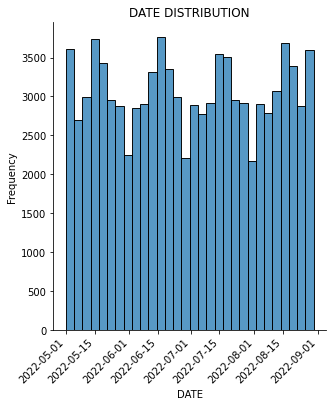

In [26]:
# Check Date 
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'])
print('Missing DATE for df_transactions: ', df_transactions['DATE'].isna().sum())
print('Lower DATE: ', np.min(df_transactions.DATE))
print('Maximum DATE: ', np.max(df_transactions.DATE))

# Plot the histogram
plt.figure(figsize=(9, 9))
sns.displot(data=df_transactions, x="DATE", bins=30)
plt.title('DATE DISTRIBUTION')
plt.xlabel('DATE')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

The time of range is quite small, including only 3 months of transactions. From this column, it is possible to extract the number of transactions made by each ID. First, in order to not bias the next metrics, all the transactions happened after the date of the target should be excluded.

In [27]:
# Join Date of the target in order to filter all the transactions that happen after that time
df_transactions = pd.merge(df_transactions, df_loans_gb[['ID', 'max_DATE', 'target']], on='ID', how='left')
df_transactions = df_transactions.dropna(subset=['target']) # we drop rows without target

# Filter out rows where DATE of the transaction is greater than MAX_DATE when the target was established
df_transactions = df_transactions[~(df_transactions['DATE'] > df_transactions['max_DATE'])]

print('Missing values for each column: ')
print(df_transactions.isna().sum())
print(df_transactions.shape)
df_transactions.head()

Missing values for each column: 
ID             0
DATE           0
AMOUNT         0
BALANCE     3725
max_DATE       0
target         0
dtype: int64
(25126, 6)


,ID,DATE,AMOUNT,BALANCE,max_DATE,target
3,O+AEF2OT,2022-07-18,-64,NaN,2022-08-22,0.0
5,CC3PAHCB,2022-05-09,-643,1599.0,2022-07-09,0.0
10,A1N76+0Y,2022-08-05,-1633,3828.0,2022-08-08,0.0
12,0NFZ2II6,2022-06-01,-1306,5649.0,2022-06-16,0.0
19,NRWVYMMV,2022-07-29,-1196,2481.0,2022-08-24,0.0


In [28]:
# Drop max_DATE and target 
df_transactions = df_transactions.drop(['max_DATE', 'target'], axis=1) #not needed anymore
print(df_transactions.shape)

# Check quality ID customers after removing future transactions
print('Shape of df_transactions: ', df_transactions.shape)
print('Missing ID for df_transactions: ', df_transactions['ID'].isna().sum())
print('Distinct ID for df_transactions: ', df_transactions.ID.nunique())
print('ID duplicates for df_transactions: ', df_transactions.duplicated(subset=['ID']).sum())

(25126, 4)
Shape of df_transactions:  (25126, 4)
Missing ID for df_transactions:  0
Distinct ID for df_transactions:  1038
ID duplicates for df_transactions:  24088


In [29]:
# Perform a left join between df_loans_gb and df_transactions on the 'ID' column
df_diff_target = pd.merge(df_loans_gb, df_transactions[['ID']], on='ID', how='left', indicator=True)

# Count the number of rows where the ID is not present in df_transactions
ids_not_in_transactions = df_diff_target[df_diff_target['_merge'] == 'left_only']['ID'].nunique()

print('Number of IDs in df_loans_gb not present in df_transactions:', ids_not_in_transactions)

Number of IDs in df_loans_gb not present in df_transactions: 310


The number of transactions drastically reduced as well as the number of distinct ID available for the modeling part. Also, the number of missing values for the features that will be extracted for the modeling part in the next steps will increase (since 310 ID do not have these metrics). However the cleaning part above was necessary to not introduce biases in the model.

(1038, 2)
(986, 2)
(1037, 2)


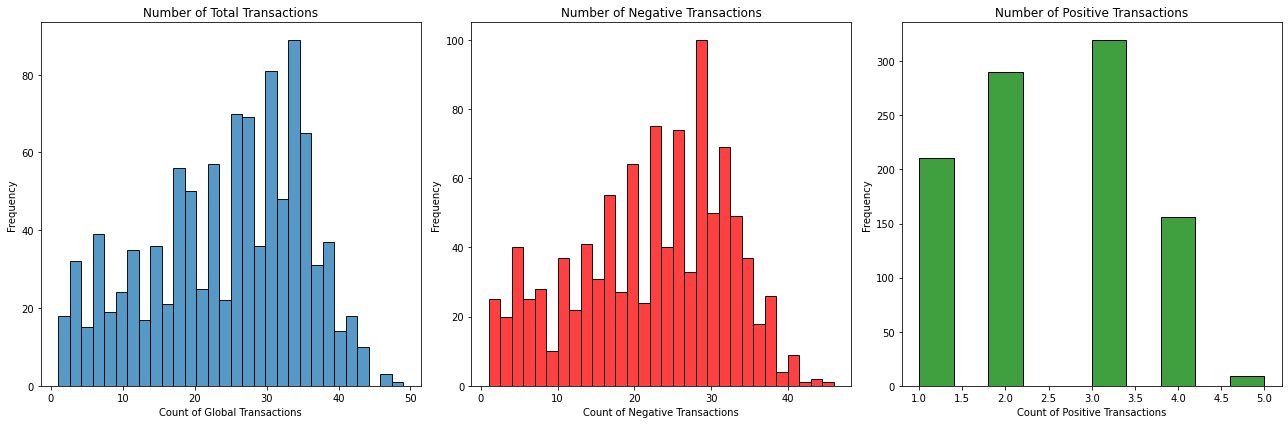

In [30]:
# Extract as first feature extract the quantity of transactions per date made by each ID
numb_transactions = df_transactions.groupby('ID').size().reset_index(name='count_trans')
# Extract number of transactions considering the Positive or Negative AMOUNT
positive_transactions = df_transactions[df_transactions['AMOUNT'] >= 0]
negative_transactions = df_transactions[df_transactions['AMOUNT'] < 0]
# Group by 'ID' and count the number of transactions
numb_transactions_positive = positive_transactions.groupby('ID').size().reset_index(name='count_trans_positive')
numb_transactions_negative = negative_transactions.groupby('ID').size().reset_index(name='count_trans_negative')

print(numb_transactions.shape)
print(numb_transactions_positive.shape) 
print(numb_transactions_negative.shape)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution for numb_transactions
sns.histplot(data=numb_transactions, x="count_trans", bins=30, ax=axes[0])
axes[0].set_title('Number of Total Transactions')
axes[0].set_xlabel('Count of Global Transactions')
axes[0].set_ylabel('Frequency')
      
# Plot the distribution for numb_transactions_negative
sns.histplot(data=numb_transactions_negative, x="count_trans_negative", bins=30, ax=axes[1], color='red')
axes[1].set_title('Number of Negative Transactions')
axes[1].set_xlabel('Count of Negative Transactions')
axes[1].set_ylabel('Frequency')

# Plot the distribution for numb_transactions_positive
sns.histplot(data=numb_transactions_positive, x="count_trans_positive", bins=10, ax=axes[2], color='green')
axes[2].set_title('Number of Positive Transactions')
axes[2].set_xlabel('Count of Positive Transactions')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

As expected, the number of payments made is higher than the number of credits received. However, the relevance of the number of credits received can be significant in the discrimination of ID who received and did not receive a loan.

Missing AMOUNT for df_transactions:  0
Lower AMOUNT:  -3095
Maximum AMOUNT:  31701


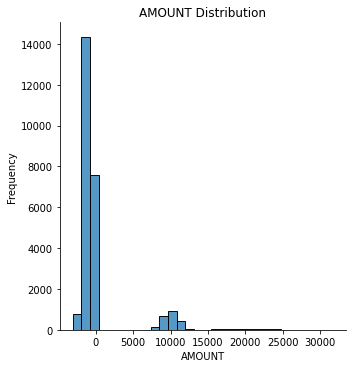

In [31]:
# Check Amount (NaN, Distribution)
print('Missing AMOUNT for df_transactions: ', df_transactions['AMOUNT'].isna().sum())
print('Lower AMOUNT: ', np.min(df_transactions.AMOUNT))
print('Maximum AMOUNT: ', np.max(df_transactions.AMOUNT))

# Plot the histogram
sns.displot(data=df_transactions, x="AMOUNT", bins=30)
plt.title('AMOUNT Distribution')
plt.xlabel('AMOUNT')
plt.ylabel('Frequency')
plt.show()

The amount of transactions shows negative and positive values. Intuitively, the negative transactions reflect the payments made by every ID. Differently, the positive transactions should reflect the amount received (e.g., salary received). From here, it is possible to extract different features as shown below.

(1038, 2)
(986, 2)
(1037, 2)


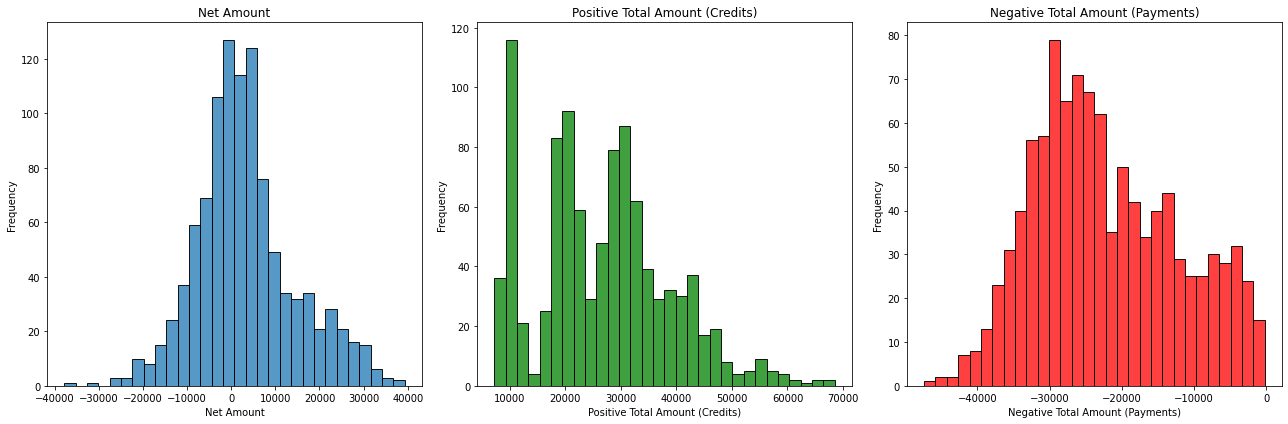

In [32]:
# Extract 3 feats: sum of all transactions, sum of payments (negative values), sum of credits received (positive values)
sum_of_amount = df_transactions.groupby('ID')['AMOUNT'].sum().reset_index(name='net_amount')
positive_sum_of_amount = df_transactions[df_transactions['AMOUNT'] >= 0].groupby('ID')['AMOUNT'].sum().reset_index(name='sum_credits')
negative_sum_of_amount = df_transactions[df_transactions['AMOUNT'] < 0].groupby('ID')['AMOUNT'].sum().reset_index(name='sum_payments')
print(sum_of_amount.shape)
print(positive_sum_of_amount.shape)
print(negative_sum_of_amount.shape)

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution for sum_of_amount
sns.histplot(data=sum_of_amount, x="net_amount", bins=30, ax=axes[0])
axes[0].set_title('Net Amount')
axes[0].set_xlabel('Net Amount')
axes[0].set_ylabel('Frequency')

# Plot the distribution for positive_sum_of_amount
sns.histplot(data=positive_sum_of_amount, x="sum_credits", bins=30, ax=axes[1], color='green')
axes[1].set_title('Positive Total Amount (Credits)')
axes[1].set_xlabel('Positive Total Amount (Credits)')
axes[1].set_ylabel('Frequency')

# Plot the distribution for negative_sum_of_amount
sns.histplot(data=negative_sum_of_amount, x="sum_payments", bins=30, ax=axes[2], color='red')
axes[2].set_title('Negative Total Amount (Payments)')
axes[2].set_xlabel('Negative Total Amount (Payments)')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

The net amount of transactions suggests a normal distribution. However, a deeper investigation shows a slight left and right distribution for negative and positive transactions respectively. This level of detail can help the model to discriminate the target.

Missing Balance for df_transactions:  3725
Percentage of Missing Balance for df_transactions: 14.83 %


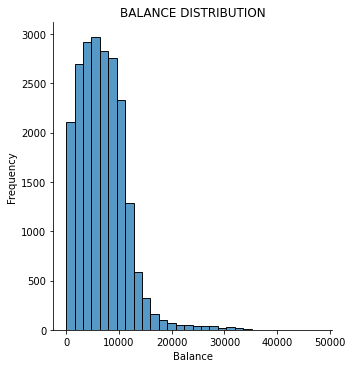

In [33]:
# Check Balance (NaN, Distribution) 
print('Missing Balance for df_transactions: ', df_transactions['BALANCE'].isna().sum())
percentage_missing = round(df_transactions['BALANCE'].isna().sum() / len(df_transactions) * 100, 2)
print('Percentage of Missing Balance for df_transactions:', percentage_missing, '%')

sns.displot(data=df_transactions, x="BALANCE", bins=30)
plt.title('BALANCE DISTRIBUTION')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

The plot shows a right skewed distribution for the balance of all the transactions with a long tail to the right, suggesting the presence of outliers. In order to be consistent with the creation of the target (i.e., where I picked the most recent OUTCOME as proxy for class 0 and 1), I will impute the NaN with mean BALANCE value of each ID, and then take the most recent balance as new feature.  After, I will extract a feature coming from a division of the Balance and Amount to get a 'balance score' for each transaction. A lower balance score should suggest a higher financial stability for the client. 

In [34]:
# Check how many IDs do not have BALANCE
missing_balance = df_transactions[df_transactions['BALANCE'].isna()]

# Calculate the total number of distinct IDs
total_distinct_ids = df_transactions['ID'].nunique()

# Calculate the number of distinct IDs with missing balance
distinct_ids_missing_balance = missing_balance['ID'].nunique()

# Calculate the percentage of distinct IDs with missing balance
percentage_missing_balance = (distinct_ids_missing_balance / total_distinct_ids) * 100

# Print the percentage
print('Percentage of distinct IDs with missing balance:', round(percentage_missing_balance, 2), '%')

Percentage of distinct IDs with missing balance: 90.56 %


9 out of 10 IDs have missing values in their balance history. However, given the small percentage of missing overall (less than 15%), we can impute the mean of the ID for these transactions.

In [35]:
# Impute missing values with the mean of each ID
df_transactions['BALANCE'] = df_transactions.groupby('ID')['BALANCE'].transform(lambda x: x.fillna(x.mean()))

# Calculate the overall mean of the 'BALANCE' column
overall_mean = df_transactions['BALANCE'].mean()
# Fill remaining NaN values with the overall mean
df_transactions['BALANCE'] = df_transactions['BALANCE'].fillna(overall_mean)

# Sort the DataFrame by DATE in descending order
df_transactions_sorted = df_transactions.sort_values(by='DATE', ascending=False)
# Group by ID and select the first row for each group
latest_balance_ID = df_transactions_sorted.groupby('ID').first()

# Extract the BALANCE column from the result
latest_balance_ID = latest_balance_ID['BALANCE'].reset_index(name='latest_balance')

print(latest_balance_ID.shape)
latest_balance_ID.head()

(1038, 2)


,ID,latest_balance
0,++SMIKU/,8945.0
1,+E4MIDN7,8023.0
2,+LDXZSXW,2753.0
3,+MMD4AEU,769.0
4,+SIVL6ZN,3210.0


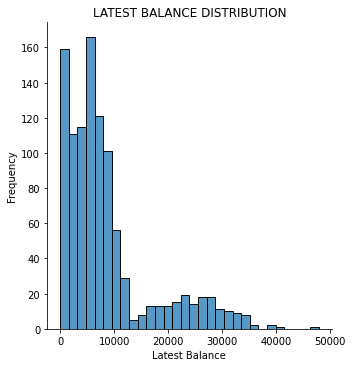

In [36]:
# Plot the distribution of the latest balance
sns.displot(data=latest_balance_ID, x="latest_balance", bins=30)
plt.title('LATEST BALANCE DISTRIBUTION')
plt.xlabel('Latest Balance')
plt.ylabel('Frequency')
plt.show()

The distribution is less smooth on the left after the transformation. I will convert the values into two different scales (lof and sqrt). I will compare the output of the 2 different transformations to see what's the best for this user case. 

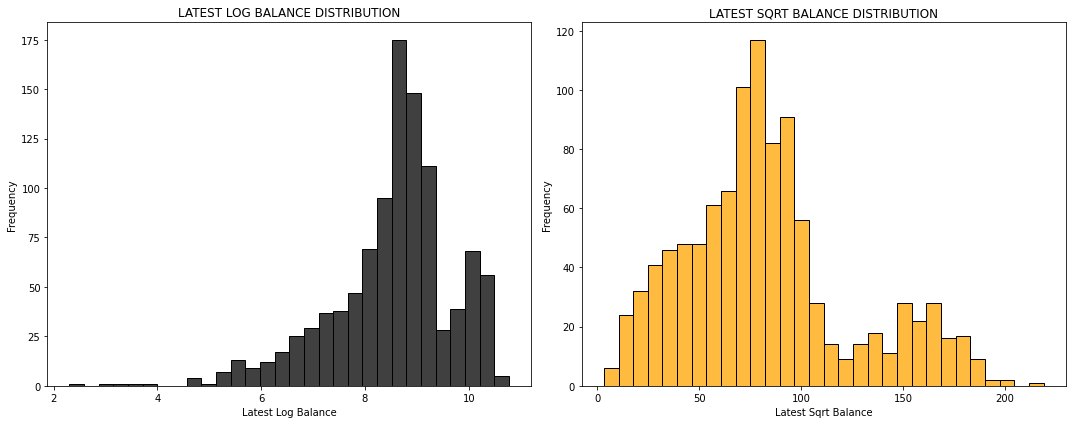

In [37]:
# Convert Latest_Balance column to log scale
latest_balance_ID['latest_balance_log'] = np.log(latest_balance_ID['latest_balance'])
# Convert Latest_Balance column to square root scale
latest_balance_ID['latest_balance_sqrt'] = round(np.sqrt(latest_balance_ID['latest_balance']), 2)

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distribution of the latest balance
sns.histplot(data=latest_balance_ID, x="latest_balance_log", bins=30, ax=axes[0], color='black')
axes[0].set_title('LATEST LOG BALANCE DISTRIBUTION')
axes[0].set_xlabel('Latest Log Balance')
axes[0].set_ylabel('Frequency')

sns.histplot(data=latest_balance_ID, x="latest_balance_sqrt", bins=30, ax=axes[1], color='orange')
axes[1].set_title('LATEST SQRT BALANCE DISTRIBUTION')
axes[1].set_xlabel('Latest Sqrt Balance')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

The Log transformation transposes the skewness of the data to the other side (from right to left skew distribution). Differently, the Sqrt transformation shaped the data suggesting (almost) a bimodal distribution. As future improvement, it would be adeguate to use different transformations or pre process the feature differently (e.g., not taking the most recent balance for example). For the purpose of this excercise, I will pick the Log scale as input for the modeling. 

In [38]:
# Filter transformation chosen
latest_balance_ID = latest_balance_ID[['ID', 'latest_balance_log']].copy()
latest_balance_ID.head()

,ID,latest_balance_log
0,++SMIKU/,9.098850
1,+E4MIDN7,8.990068
2,+LDXZSXW,7.920447
3,+MMD4AEU,6.645091
4,+SIVL6ZN,8.074026


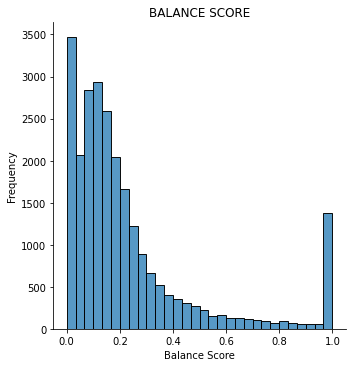

In [39]:
# Divide AMOUNT with BALANCE in order to get for each transaction a 'balance-score' (lower indicates better stability) 

# Apply lambda function to calculate balance_score
df_transactions['balance_score'] = df_transactions.apply(lambda row: 0 if row['AMOUNT'] > 0 
                                                         else min(abs(row['AMOUNT']) / row['BALANCE'], 1) if row['BALANCE'] != 0 else 0, axis=1)
#if AMOUNT positive (so the Balance will increase) we assign 0 for balance score (min value)
#if BALANCE is negative we assign max value of the score (1)
#if b_score > 1 we assign 1 as max value 

# Plot the distribution of the latest balance
sns.displot(data=df_transactions, x="balance_score", bins=30)
plt.title('BALANCE SCORE')
plt.xlabel('Balance Score')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Get avg balance score in the last 3 months + the most recent balance score
balance_score_df = df_transactions.groupby('ID').agg(
    recent_bscore=('balance_score', lambda x: x.iloc[-1]),  # Most recent balance_score
    avg_bscore=('balance_score', 'mean')  # Average balance_score
)

# Reset index to make 'ID' a column again
balance_score_df = balance_score_df.reset_index()
balance_score_df = balance_score_df.round({'recent_bscore': 2, 'avg_bscore': 2})

print(balance_score_df.shape)
balance_score_df.head()

(1038, 3)


,ID,recent_bscore,avg_bscore
0,++SMIKU/,0.25,0.13
1,+E4MIDN7,0.09,0.21
2,+LDXZSXW,0.19,0.29
3,+MMD4AEU,0.00,0.15
4,+SIVL6ZN,0.22,0.26


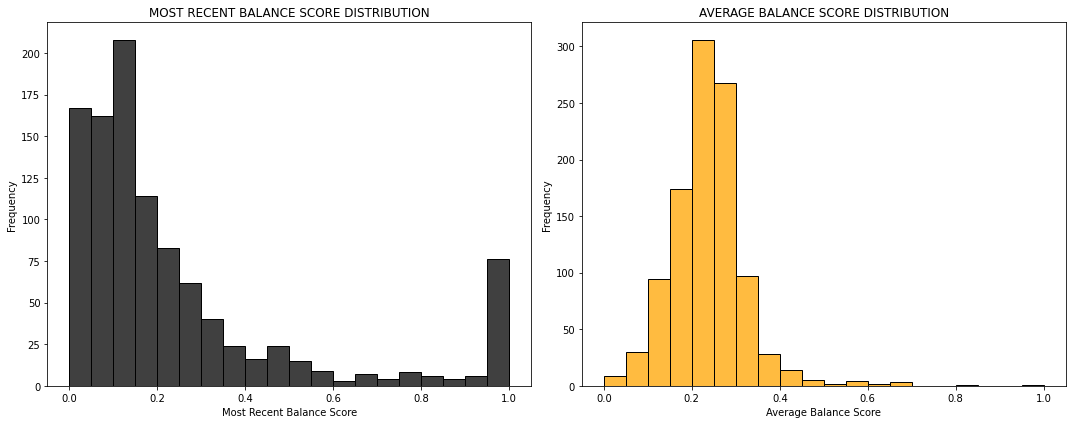

In [41]:
# Visualize the new features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distribution of the most recent balance score and average balance score
sns.histplot(data=balance_score_df, x="recent_bscore", bins=20, ax=axes[0], color='black')
axes[0].set_title('MOST RECENT BALANCE SCORE DISTRIBUTION')
axes[0].set_xlabel('Most Recent Balance Score')
axes[0].set_ylabel('Frequency')

sns.histplot(data=balance_score_df, x="avg_bscore", bins=20, ax=axes[1], color='orange')
axes[1].set_title('AVERAGE BALANCE SCORE DISTRIBUTION')
axes[1].set_xlabel('Average Balance Score')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [42]:
# Merge all the features in one
# AMOUNT FEATS
feats_df = pd.merge(sum_of_amount, positive_sum_of_amount, on='ID', how='outer')
feats_df = pd.merge(feats_df, negative_sum_of_amount, on='ID', how='outer')

# TRANSACTIONS FEATS
feats_df = pd.merge(feats_df, numb_transactions, on='ID', how='outer')
feats_df = pd.merge(feats_df, numb_transactions_negative, on='ID', how='outer')
feats_df = pd.merge(feats_df, numb_transactions_positive, on='ID', how='outer')

# BALANCE FEAT
feats_df = pd.merge(feats_df, latest_balance_ID, on='ID', how='outer')

# CUSTOMER FEATS
feats_df = pd.merge(feats_df, df_customers, on='ID', how='outer')

# BALANCE-SCORE FEATS
feats_df = pd.merge(feats_df, balance_score_df, on='ID', how='outer')

print(feats_df.shape)
print(' ')
print('Missing values for each column: ')
print(feats_df.isna().sum())
feats_df.head()

(2500, 13)
 
Missing values for each column: 
ID                         0
net_amount              1462
sum_credits             1514
sum_payments            1463
count_trans             1462
count_trans_negative    1463
count_trans_positive    1514
latest_balance_log      1462
GENDER                     0
AGE                        0
INCOME                     0
recent_bscore           1462
avg_bscore              1462
dtype: int64


,ID,net_amount,sum_credits,sum_payments,count_trans,count_trans_negative,count_trans_positive,latest_balance_log,GENDER,AGE,INCOME,recent_bscore,avg_bscore
0,++SMIKU/,5495.0,9942.0,-4447.0,6.0,5.0,1.0,9.098850,0,30.0,9942.0,0.25,0.13
1,+E4MIDN7,1455.0,32427.0,-30972.0,29.0,26.0,3.0,8.990068,0,44.0,10809.0,0.09,0.21
2,+LDXZSXW,1118.0,23918.0,-22800.0,17.0,15.0,2.0,7.920447,0,46.0,11959.0,0.19,0.29
3,+MMD4AEU,-18307.0,21226.0,-39533.0,42.0,40.0,2.0,6.645091,0,20.0,10613.0,0.00,0.15
4,+SIVL6ZN,5476.0,34803.0,-29327.0,29.0,26.0,3.0,8.074026,0,44.0,11601.0,0.22,0.26


In [43]:
# Join the features with the target stored in df_loans_gb
model_df = pd.merge(df_loans_gb, feats_df, on='ID', how='outer')
print('Shape of the modeling df: ', model_df.shape)
print(' ')
print('Missing values for each column: ')
print(model_df.isna().sum())
model_df.head()

Shape of the modeling df:  (2500, 16)
 
Missing values for each column: 
ID                         0
target                  1152
max_DATE                1152
loan_amt                1152
net_amount              1462
sum_credits             1514
sum_payments            1463
count_trans             1462
count_trans_negative    1463
count_trans_positive    1514
latest_balance_log      1462
GENDER                     0
AGE                        0
INCOME                     0
recent_bscore           1462
avg_bscore              1462
dtype: int64


,ID,target,max_DATE,loan_amt,net_amount,sum_credits,sum_payments,count_trans,count_trans_negative,count_trans_positive,latest_balance_log,GENDER,AGE,INCOME,recent_bscore,avg_bscore
0,++SMIKU/,0.0,2022-05-23,16021.0,5495.0,9942.0,-4447.0,6.0,5.0,1.0,9.098850,0,30.0,9942.0,0.25,0.13
1,++YL0APY,1.0,2022-04-17,14603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,36.0,10385.0,NaN,NaN
2,+E4MIDN7,0.0,2022-08-21,18517.0,1455.0,32427.0,-30972.0,29.0,26.0,3.0,8.990068,0,44.0,10809.0,0.09,0.21
3,+EF470O/,0.0,2022-01-15,17734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27.0,10068.0,NaN,NaN
4,+LDXZSXW,0.0,2022-07-02,25138.0,1118.0,23918.0,-22800.0,17.0,15.0,2.0,7.920447,0,46.0,11959.0,0.19,0.29


In [44]:
# Find distinct IDs without a target value
ids_without_target = model_df[model_df['target'].isnull()]['ID'].unique()
print("Number of distinct IDs without a target value:", len(ids_without_target))

# Find distinct IDs with a target value
ids_with_target = model_df[~model_df['target'].isnull()]['ID'].unique()
print("Number of distinct IDs with a target value:",  len(ids_with_target))

Number of distinct IDs without a target value: 1152
Number of distinct IDs with a target value: 1348


In [45]:
# Filter out IDs without target 
model_df = model_df.dropna(subset=['target'])
model_df['target'] = model_df['target'].astype(int)
model_df.columns = map(str.lower, model_df.columns)

print('Number of unique IDs: ', model_df.id.nunique())
print('Shape of the modeling dataframe: ', model_df.shape)
model_df = model_df.drop(['id', 'max_date'], axis=1) #ID not needed for the next steps
model_df.head()

Number of unique IDs:  1348
Shape of the modeling dataframe:  (1348, 16)


,target,loan_amt,net_amount,sum_credits,sum_payments,count_trans,count_trans_negative,count_trans_positive,latest_balance_log,gender,age,income,recent_bscore,avg_bscore
0,0,16021.0,5495.0,9942.0,-4447.0,6.0,5.0,1.0,9.098850,0,30.0,9942.0,0.25,0.13
1,1,14603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,36.0,10385.0,NaN,NaN
2,0,18517.0,1455.0,32427.0,-30972.0,29.0,26.0,3.0,8.990068,0,44.0,10809.0,0.09,0.21
3,0,17734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27.0,10068.0,NaN,NaN
4,0,25138.0,1118.0,23918.0,-22800.0,17.0,15.0,2.0,7.920447,0,46.0,11959.0,0.19,0.29


In [46]:
# Calculate the percentage of missing values for each column
percentage_missing_values = round(((model_df.isna().sum() / len(model_df)) * 100), 2)

# Print the percentage of missing values for each column
print('Percentage of missing values for each column:', percentage_missing_values)

Percentage of missing values for each column: target                   0.00
loan_amt                 0.00
net_amount              23.00
sum_credits             26.85
sum_payments            23.07
count_trans             23.00
count_trans_negative    23.07
count_trans_positive    26.85
latest_balance_log      23.00
gender                   0.00
age                      0.00
income                   0.00
recent_bscore           23.00
avg_bscore              23.00
dtype: float64


Given the distributions of all the features containing the missing values, I will impute missing values with their relative Median values. The mean can be affected from the presence of outliers. Median is more robust in this case. As future direction, consider to treat these variables differently (e.g., using binning)

In [47]:
# Impute the median to the columns containing missing values
model_df.fillna(model_df.median(), inplace=True)

# Calculate the percentage of missing values for each column
percentage_missing_values = round(((model_df.isna().sum() / len(model_df)) * 100), 2)
# Print the percentage of missing values for each column
print('Percentage of missing values for each column:', percentage_missing_values)

Percentage of missing values for each column: target                  0.0
loan_amt                0.0
net_amount              0.0
sum_credits             0.0
sum_payments            0.0
count_trans             0.0
count_trans_negative    0.0
count_trans_positive    0.0
latest_balance_log      0.0
gender                  0.0
age                     0.0
income                  0.0
recent_bscore           0.0
avg_bscore              0.0
dtype: float64


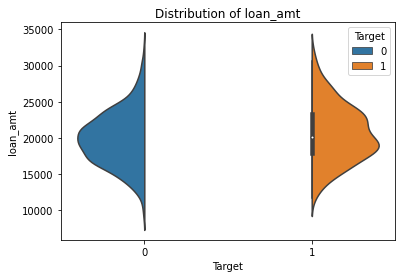

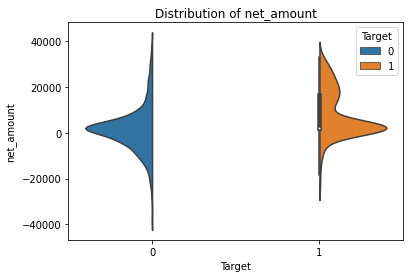

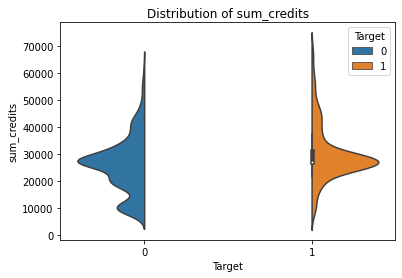

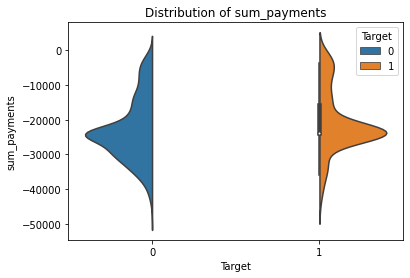

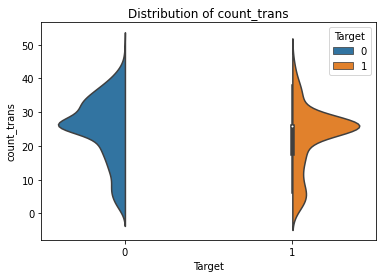

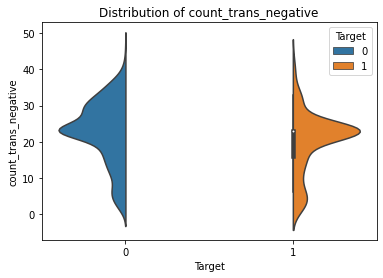

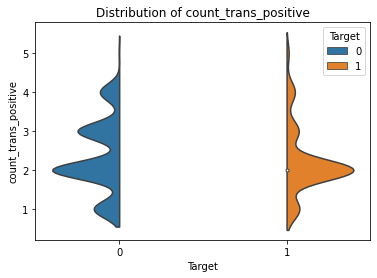

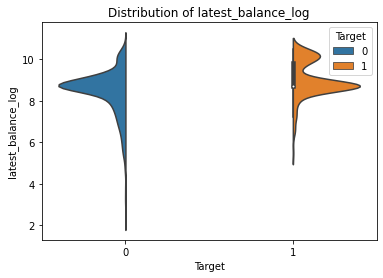

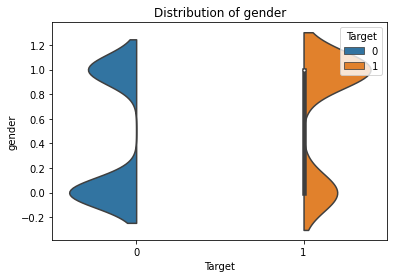

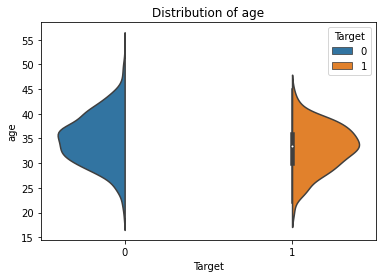

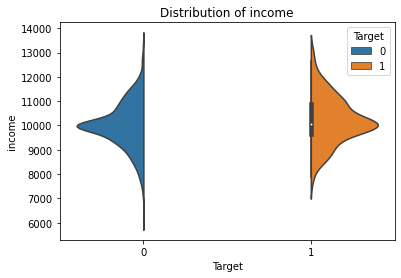

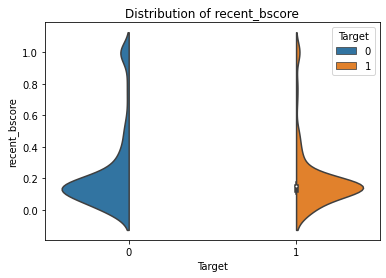

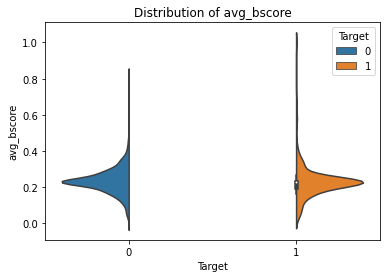

In [48]:
# Visualize features according to the target
for x in model_df.columns:
    if x != 'target':  # Exclude 'target' column
        sns.violinplot(data=model_df, x='target', y=x, hue='target', split=True)
        plt.title('Distribution of ' + x)
        plt.xlabel('Target')
        plt.ylabel(x)
        plt.legend(title='Target')
        plt.show()

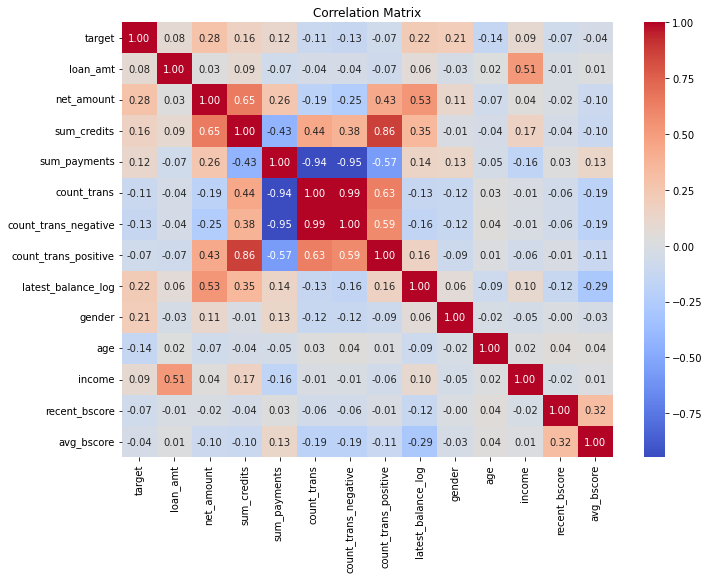

In [49]:
#Check Correlation among features
# Set the size of the figure
plt.figure(figsize=(11, 8))
corr = model_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show() 

It is possible to detect some small differences in the distribution of the variables according to the target, in particular for the net amount where Pearson coeff=0.28. Ideally, Highly correlated features(e.g., count of transactions, count of negative transactions and sum of payments) should be removed to avoid the risk of multicollinearity of the features. Considering the size of the dataframe and the relaively low number of features extracted, I will accept these preliminary results as they are. To mitigate the risk described, I will use XXX

# Question 5 and 6: 
- Use the available datasets to create train and validation datasets for the task identifying which clients should we approach with a loan offer.
- Train and evaluate a machine learning model for the aforementioned task. Explain your approach as much as possible.

Given the small size of the data at my disposal, I can not use a balanced approach, sampling the dataset with 50% of the class 0 and 50% of the class 1. I will just drop a small percentage in order to get a negative class of 2/3 of the sample

In [50]:
print('Target ratio: ')
model_df.target.value_counts()

Target ratio: 


0    1052
1     296
Name: target, dtype: int64

In [51]:
# Reduce sample in the negative class 
class_counts = model_df['target'].value_counts()
sample_size_class_0 = int(class_counts[0] * 0.6)  # Sample 60% of class 0

# Sample from class 0
class_0_sample = model_df[model_df['target'] == 0].sample(n=sample_size_class_0, random_state=42)

# Filter class 1 instances
class_1_instances = model_df[model_df['target'] == 1]

# Concatenate the sampled class 0 instances and all class 1 instances
model_df = pd.concat([class_0_sample, class_1_instances])

# Shuffle the DataFrame to mix class 0 and class 1 instances
model_df = model_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(model_df.shape)
print(model_df['target'].value_counts()) 

(927, 14)
0    631
1    296
Name: target, dtype: int64


In [52]:
# Split train and test (80% and 20%)
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(
    columns=['target']), model_df['target'], test_size=0.2, stratify=model_df['target'], random_state=42
) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(741, 13) (186, 13) (741,) (186,)


,loan_amt,net_amount,sum_credits,sum_payments,count_trans,count_trans_negative,count_trans_positive,latest_balance_log,gender,age,income,recent_bscore,avg_bscore
491,19187.0,2110.5,26880.0,-23854.0,26.0,23.0,2.0,8.717273,1,26.0,10002.903529,0.15,0.23
839,13499.0,2081.0,11233.0,-9152.0,9.0,8.0,1.0,9.318298,1,24.0,10002.903529,0.10,0.18
163,21348.0,4692.0,10863.0,-6171.0,7.0,6.0,1.0,9.027259,0,31.0,10002.903529,0.09,0.25
864,18645.0,-5769.0,20738.0,-26507.0,26.0,24.0,2.0,7.388328,1,35.0,10369.000000,0.07,0.23
776,18949.0,16707.0,47350.0,-30643.0,37.0,33.0,4.0,8.453401,1,26.0,10002.903529,0.17,0.20


Before to proceed with the modeling part, some features need to be pre processed before to be used as input for the model (i.e., standardize the values also called z score normalization)

In [53]:
# Standardize features according to the train values
cols_to_std = ['loan_amt', 'net_amount', 'sum_credits', 'sum_payments', 'count_trans', 'count_trans_negative', 'age', 'income', 'recent_bscore', 'avg_bscore', 'latest_balance_log']
train_mean = X_train.loc[:, cols_to_std].mean(skipna=True)
train_std = X_train.loc[:, cols_to_std].std(skipna=True)

# Scale train and test features using formula below:
X_train.loc[:, cols_to_std] = (X_train.loc[:, cols_to_std] - train_mean) / train_std
X_test.loc[:, cols_to_std] = (X_test.loc[:, cols_to_std] - train_mean) / train_std
X_train.head()

,loan_amt,net_amount,sum_credits,sum_payments,count_trans,count_trans_negative,count_trans_positive,latest_balance_log,gender,age,income,recent_bscore,avg_bscore
491,-0.247702,-0.171633,-0.017541,-0.202627,0.198705,0.158312,2.0,0.091558,1,-1.697736,-0.093892,-0.259534,-0.060833
839,-1.749592,-0.174671,-1.581060,1.429679,-1.577797,-1.545114,1.0,0.660813,1,-2.109662,-0.093892,-0.478622,-0.690402
163,0.322900,0.094178,-1.618032,1.760648,-1.786798,-1.772238,1.0,0.385158,0,-0.667921,-0.093892,-0.522439,0.190995
864,-0.390815,-0.982968,-0.631278,-0.497179,0.198705,0.271874,2.0,-1.167139,1,0.155932,0.293693,-0.610074,-0.060833
776,-0.310545,1.331335,2.027914,-0.956383,1.348207,1.293930,4.0,-0.158365,1,-1.697736,-0.093892,-0.171899,-0.438574


Cross-Validation AUC Scores: [0.86528029 0.8662598  0.85631404]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       127
           1       0.64      0.83      0.73        59

    accuracy                           0.80       186
   macro avg       0.78      0.81      0.78       186
weighted avg       0.83      0.80      0.81       186



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


array([[100,  27],
       [ 10,  49]])

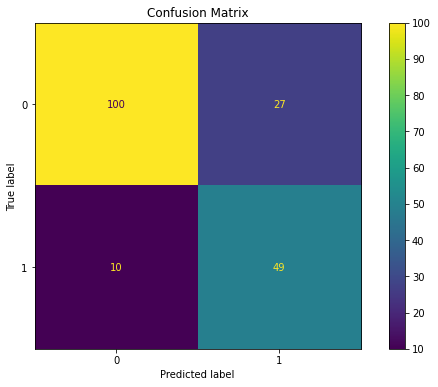

In [54]:
# Modeling LogReg
logreg = LogisticRegression(solver='lbfgs', penalty='l2', C=1, class_weight = 'balanced', max_iter=1000)

# Perform cross-validation
cv_scores = cross_val_score(logreg, X_train, y_train, cv=3, scoring="roc_auc")  

# Fit the model using the entire training data
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test) 

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)

# Print classification report
print(metrics.classification_report(y_test, y_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrix')
disp = metrics.plot_confusion_matrix(logreg, X_test, y_test, ax=ax)
disp.confusion_matrix

The confusion matrix shows the good results obtained in the model. The model is able to predict correctly the respective classes as shown in True Positive and True Negative. Moreover, the number of False Positive is relatively low. Translated into the business context, it means that the model is able to discriminate well the people that should not receive any loan, decreasing the risks for the bank that grants the loan. At the same time, it is able to recognize people eligible for loans, without inflating the number of False Positives. The threshold of the model should be adapted to the business context, taking into account the risks of default on the loans.

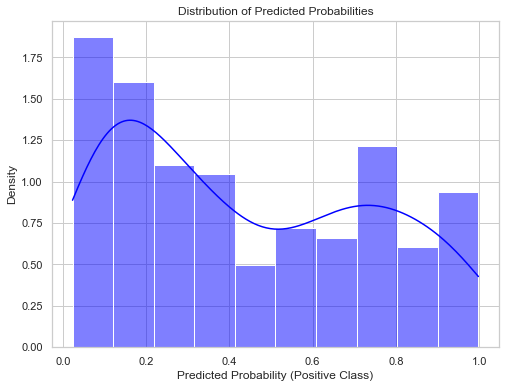

In [55]:
# Prediction
Y_pred = logreg.predict(X_test)
Y_pred_train = logreg.predict(X_train)

# Get predicted probabilities for the positive class (class 1)
Y_pred_probs = logreg.predict_proba(X_test)[:, 1]
Y_pred_probs_train = logreg.predict_proba(X_train)[:, 1]

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(Y_pred_probs, bins=10, kde=True, color='blue', stat='density')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability (Positive Class)')
plt.ylabel('Density')
plt.show()

As expected, the distribution of the probabilities confirm a high number of lower probabilities and a low number of high probabilities.
The intermediate deciles (4th, 5th, 6th) have a lower density while the deciles at the bottom and at the top of the rank are more densed, suggesting a good confidence of the model to predict both classes. 

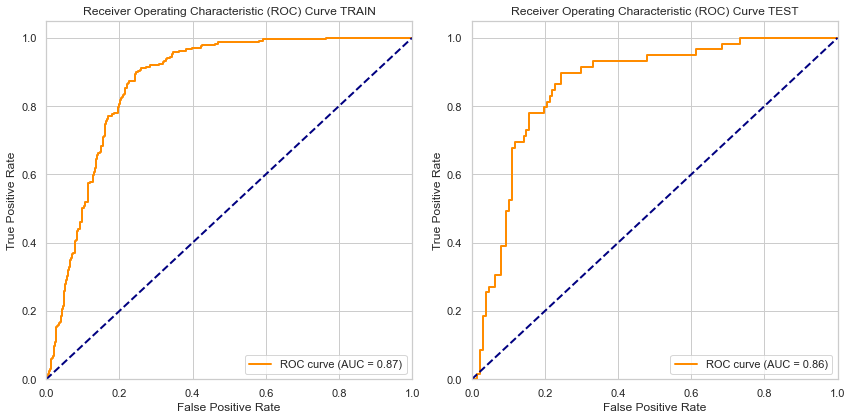

In [56]:
# Calculate ROC curve and AUC for TRAIN
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, Y_pred_probs_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve and AUC for TEST
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, Y_pred_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves in subplots
plt.figure(figsize=(12, 6))

# Subplot 1 for TRAIN ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve TRAIN')
plt.legend(loc='lower right')

# Subplot 2 for TEST ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve TEST')
plt.legend(loc='lower right')

# Adjust layout and save the plot
plt.tight_layout()
plt.show()

In [57]:
# Extract coefficients 
coefficients = logreg.coef_
intercepts = logreg.intercept_
feature_names = list(X_train.columns)

# Create a mapping of feature names to their coefficients using a dictionary comprehension
feature_coefficients = {feature_names[i]: coefficients[:, i] for i in range(len(feature_names))}

# Create a DataFrame from the feature_coefficients dictionary
df_coef = pd.DataFrame(feature_coefficients).T
df_coef = df_coef.reset_index()
df_coef.columns = ['feature', 'coeff']

df_coef['abs_coeff'] = abs(df_coef.coeff)
print(f"Intercepts: {intercepts}")
print("Coefficients (Weights) for each Feature:")
print(df_coef.shape)
df_coef.sort_values(by='abs_coeff', ascending=False)

Intercepts: [6.65507414]
Coefficients (Weights) for each Feature:
(13, 3)


,feature,coeff,abs_coeff
6,count_trans_positive,-3.238147,3.238147
2,sum_credits,2.633722,2.633722
4,count_trans,1.295017,1.295017
8,gender,0.936793,0.936793
3,sum_payments,0.798902,0.798902
9,age,-0.316036,0.316036
1,net_amount,0.291867,0.291867
11,recent_bscore,-0.221274,0.221274
5,count_trans_negative,-0.220231,0.220231
0,loan_amt,-0.203939,0.203939


About the interpretability and valence of the features, the table above shows how 
having a higher credits received (sum_credits) increase the odds of having a loan. Same logic is applied for number of transactions (count_trans) and sum payments with lower coefficients. As expected, also a higher net amount and positive balance (latest_balance_log) increase the chance to be approachable for a loan.
Differently, a higher number of transactions both received and made (count_trans_positive, count_trans_negative), a higher balance score (recent_bscore as risk of financial instability), and a higher amount of loan requested (loan_amt) decrease the odds of loan approval. 
Additionally, being female and younger (gender and age) are associated with higher probabilities to be associated with target 1.

# Question 7: Hypothetically, could you improve the solution? What would you require for it?

FUTURE DIRECTIONS
1) Retrieve More Data: collecting more data to get a more comprehensive understanding of the patterns and relationships within the data.
2) Creation of the Target Variable: Explore alternative methods for defining the target variable (i.e., taking the average of outcomes to classify target 1 and 0 instead of the most recent date).
3) Improve Feature Engineering: Split features based on time (e.g., monthly) to analyze the progression of variables over time. 
4) Binning: Treat features by converting them into categorical instead of continuous (and processed with standardization).  
4) Creation of Credit Score: Develop a credit scoring formula by tuning the weight of the variables extracted (e.g., using grid search to find the optimal combination of weights that maximize the correlation with the target variable).
5) Balanced Approach in Train/Test split: Utilize a more balanced approach (e.g., retrieving more data or by employing techniques like oversampling).
6) Explore Different Models: Experiment different ML models besides logistic regression (e.g., random forrest)